In [157]:
import geoutils.utils.file_utils as fut
import climnet.network.network_functions as nwf
import graph_tool.all as gt
import climnet.network.boundary_correction as bc
import climnet.datasets.evs_dataset as cds
import xarray as xr
import geoutils.utils.time_utils as tu
import geoutils.utils.general_utils as gut
from importlib import reload
import numpy as np
import geoutils.tsa.time_series_analysis as tsa
import climnet.network.clim_networkx as cn
import geoutils.plotting.plots as cplt
import matplotlib.pyplot as plt

### Load Dataset and Network
For the analysis two different objects are required: 
- the dataset containing the data
- the network containing the information about the interconnections of locations

Both clases  are implemented in the climnet package. The node numbers correspond to the points dimension of the dataset. 

It is therefore required to pass the dataset class to the network to ensure that both network and dataset are consistent.

In [4]:
# Load the dataset
name = 'mswep'
start_month = 'Jun'
end_month = 'Sep'
grid_type = "fekete"
grid_step = 2.5
q_ee = 0.9
q_sig = 0.95

output_dir = '/mnt/m/Users/Hendrik/git/climnet/outputs/'
plot_dir = '/mnt/m/Users/Hendrik/git/climnet/plots/'
data_dir = '/mnt/m/Users/Hendrik/git/climnet/data/climate_data/'
output_folder = 'bsiso'

name_prefix = f"{name}_{grid_type}_{grid_step}_{q_ee}"

lb = True
# BSISO domain
lat_range = [-15, 45]
lon_range = [55, 150]

nx_path_file = output_dir + \
    f"{output_folder}/{name_prefix}_{q_sig}_lat_{lat_range}_lon_{lon_range}_ES_nx.gml.gz"
new_ds_file = output_dir + \
    f"/{output_folder}/{name_prefix}_1979_2021_lat_{lat_range}_lon_{lon_range}_ds.nc"
ds = cds.EvsDataset(
    load_nc=new_ds_file,
    rrevs=False
)

Loading Data...
Load Dataset: /mnt/m/Users/Hendrik/git/climnet/outputs//bsiso/mswep_fekete_2.5_0.9_1979_2021_lat_[-15, 45]_lon_[55, 150]_ds.nc
Variables in dataset: ['pr', 'evs']
Set variable name to evs!
WARNING! No mask initialized!
Evs datat is stored in dataset.
Init spatial evs-mask for EVS data of shape: (15339, 761)
... Finished Initialization EVS-spatial mask
Init the point-idx dictionaries


In [5]:
# and load the network
reload(cn)
cnx = cn.Clim_NetworkX(dataset=ds, nx_path_file=nx_path_file)

Load /mnt/m/Users/Hendrik/git/climnet/outputs/bsiso/mswep_fekete_2.5_0.9_0.95_lat_[-15, 45]_lon_[55, 150]_ES_nx.gml.gz...


... Loading /mnt/m/Users/Hendrik/git/climnet/outputs/bsiso/mswep_fekete_2.5_0.9_0.95_lat_[-15, 45]_lon_[55, 150]_ES_nx.gml.gz successful!
WARNING! Undirected graph object!
Casted to DiGraph object!
No isolated nodes!
Create ds for all attributes present in node 0.
Network is unweighted!
Network Info: {'Num_nodes': 714, 'Num_edges': 25446, 'sparsity': 0.049914083280370974, 'Node_attrs': ['lon', 'lat'], 'Edge_attrs': ['weight']}


In [6]:
import climnet.community_detection.graph_tool.gt_functions as gtf
reload(gtf)
theta = gtf.apply_SBM(g=cnx.cnx, B_max=6,
                      multi_level=False,)
reload(nwf)
_ = nwf.set_node_attr_array(cnx.cnx,  theta['node_levels'][0], "community_number")

Graph N 714, B 20324
Finished creating gt-graph! Summary:
<Graph object, directed, with 714 vertices and 20324 edges, at 0x7f2b6e20c810>
Start computing SBM on graph...
Compute Blockmodel on single level...
Finished minimize 1 - level Blockmodel!
 Finished MCMC search! Improvement: 0.0
Sample from the posterior in 1000 samples!
Finished sampling from the posterior.
New number of groups: 6 < previous: 715
Elapsed time for SBM: 4.67
Set Node Attribute {attr_name}...


In [7]:
from sklearn.metrics.cluster import contingency_matrix

In [8]:
def match_labels(theta1, theta2):
    '''
    Match the labels of two community detection results

    Parameters
    ----------
    theta1 : dict
        community detection result
    theta2 : dict
        community detection result

    Returns
    -------
    theta1 : dict
        community detection result with matched labels
    '''
    cm = contingency_matrix(theta1['node_levels'][0], theta2['node_levels'][0])
    most_likely_labels = cm.argmax(axis=1)
    unique_labels = np.unique(most_likely_labels).shape[0]

    # If direct mapping is not possible, manually construct it
    if unique_labels != cm.shape[0]:
        probabilities = cm.max(axis=1) / cm.sum(axis=1)
        replacement_map = {}
        while len(replacement_map) < cm.shape[0]:
            max_idx = probabilities.argmax()
            sorted_idx = np.argsort(cm[max_idx])[::-1]
            sorted_idx = sorted_idx[np.isin(sorted_idx, list(replacement_map.values()), invert=True)] # filter out already assigned labels
            probabilities[max_idx] = 0
            replacement_map[max_idx] = sorted_idx[0]
    else:
        replacement_map = {i: label for i, label in enumerate(most_likely_labels)}

    # Apply the mapping
    theta1['node_levels'][0] = np.array([replacement_map[label] for label in theta1['node_levels'][0]])

    return theta1

In [152]:
from joblib import Parallel, delayed
thetas = [gtf.apply_SBM(g=cnx.cnx, B_max=6,
                      multi_level=False,) for _ in range(20)]

Graph N 714, B 20324
Finished creating gt-graph! Summary:
<Graph object, directed, with 714 vertices and 20324 edges, at 0x7f2b4eac4c10>
Start computing SBM on graph...
Compute Blockmodel on single level...
Finished minimize 1 - level Blockmodel!
 Finished MCMC search! Improvement: 0.0
Sample from the posterior in 1000 samples!
Finished sampling from the posterior.
New number of groups: 6 < previous: 715
Elapsed time for SBM: 2.29
Graph N 714, B 20324
Finished creating gt-graph! Summary:
<Graph object, directed, with 714 vertices and 20324 edges, at 0x7f2b4e5b8f10>
Start computing SBM on graph...
Compute Blockmodel on single level...
Finished minimize 1 - level Blockmodel!
 Finished MCMC search! Improvement: 0.0
Sample from the posterior in 1000 samples!
Finished sampling from the posterior.
New number of groups: 6 < previous: 715
Elapsed time for SBM: 2.49
Graph N 714, B 20324
Finished creating gt-graph! Summary:
<Graph object, directed, with 714 vertices and 20324 edges, at 0x7f2b4e4

In [153]:
def label_probabilities(thetas):
    if len(thetas) > 1:
        thetas = [thetas[0]] + [match_labels(theta, thetas[0]) for theta in thetas[1:]]

    labels = np.stack([theta['node_levels'][0] for theta in thetas])
    unique_labels = np.unique(labels)
    probabilities = np.zeros((unique_labels.shape[0], labels.shape[1]))
    for i, label in enumerate(unique_labels):
        probabilities[i] = (labels == label).mean(axis=0)

    return probabilities.argmax(axis=0), probabilities

In [154]:
labels, probabilities = label_probabilities(thetas)

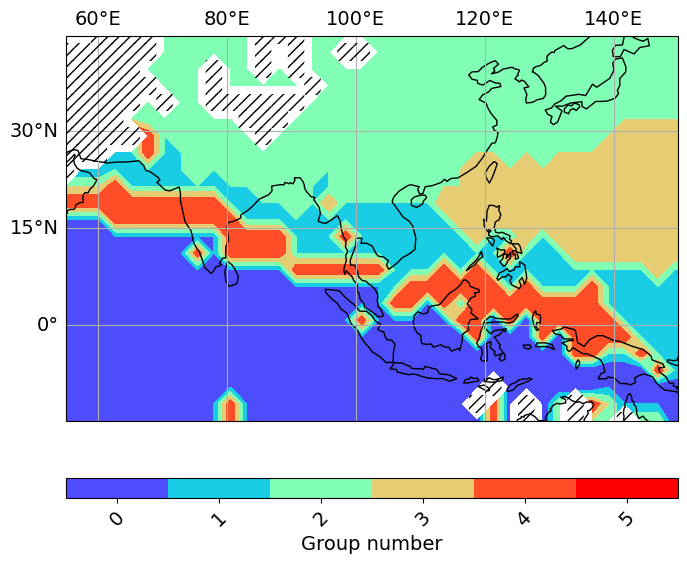

In [155]:
reload(cplt)
hard_cluster = labels # theta['node_levels'][0]
hc_map = cnx.ds.get_map(hard_cluster)
im = cplt.plot_map(
    hc_map,
    ds=cnx.ds,
    significance_mask=True,
    plot_type="discrete",
    projection="PlateCarree",
    cmap='rainbow',
    extend="neither",
    label="Group number",
    plt_grid=True,
    orientation="horizontal",
)

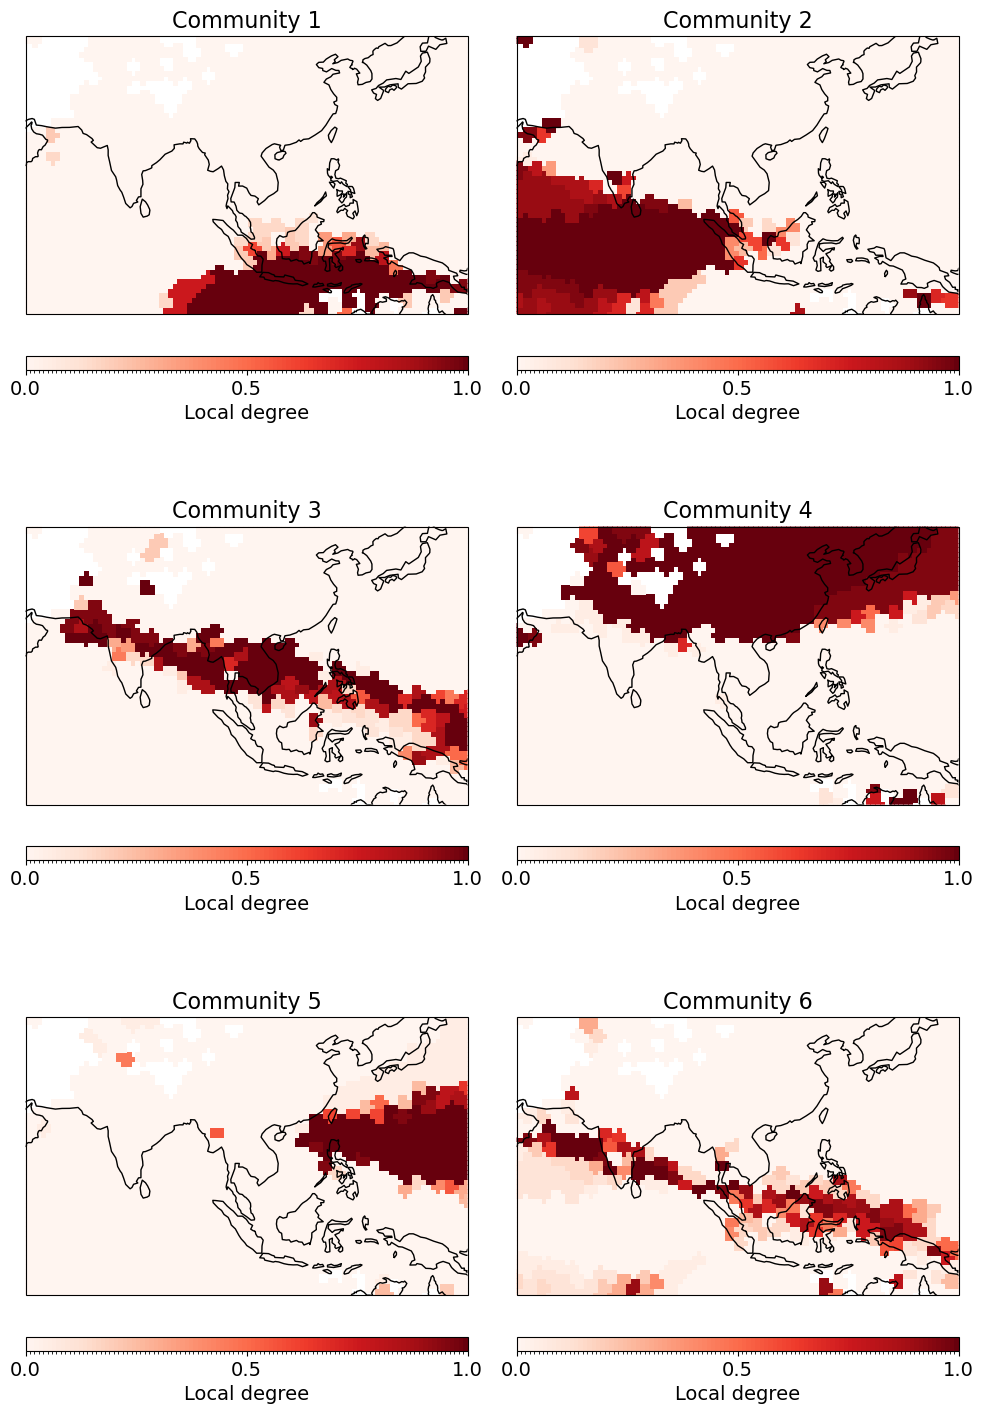

In [164]:
map_dict = cnx.get_edges_nodes_for_region(
    lon_range=lon_range, lat_range=lat_range, binary=False
)

import cartopy.crs as ccrs
fig, ax = plt.subplots(3, 2, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

for i, axi in enumerate(ax.flatten()):
    axi.set_title(f"Community {i+1}")
    map_dict['target_map'].values[~np.isnan(map_dict['target_map'].values)] = probabilities[i]

    _ = cplt.plot_map(
        map_dict['target_map'],
        ax=axi,
        label=f"Local degree",
        #projection="PlateCarree",
        plt_grid=False,
        plot_type="colormesh",
        cmap="Reds",
        vmin=0,
        vmax=1,
        levels=100,
        bar=False,
        size=1,
        tick_step=50,
        fillstyle="none",
    )

fig.tight_layout()